<a href="https://colab.research.google.com/github/snjugunanjenga/google-devs-python-machine-learning/blob/main/mit_Building_a_Handbags_Shoes_Classifier_Section_A.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Building a Handbags-Shoes Classifier with Transfer Learning

* Based on [Deep Learning with Python](https://www.manning.com/books/deep-learning-with-python-second-edition?gclid=CjwKCAjw9aiIBhA1EiwAJ_GTSlKgxc4qopKHPsFWryOoTz7fvhvhzYSjEsgQ-bG1R51QSGppISywpBoClcIQAvD_BwE) by Francois Chollett

## Introduction

In this Colab, we will first build a **convolutional neural network** from scratch.

We will then describe a very powerful technique called **Transfer Learning** that can be used to build highly accurate image classification models even when you have very little data. Pretty much any consumer-facing app that uses image AI was probably built using this technique.

We also show how to use a technique called **data augmentation** to effortlessly increase the size of your training dataset, and thereby achieve better accuracy.

---


---

But, as usual, let's get the usual technical preliminaries out of the way first.

In [1]:
!!pip install -q git+https://github.com/keras-team/keras-hub.git
!!pip install -q --upgrade keras  # Upgrade to Keras 3.

[]

In [2]:
import os
import json
import math
import numpy as np
import matplotlib.pyplot as plt

import keras
from keras import losses
from keras import ops
from keras import optimizers
from keras.optimizers import schedules
from keras import metrics
from keras.applications.imagenet_utils import decode_predictions
import keras_hub

# Import tensorflow for `tf.data` and its preprocessing functions
import tensorflow as tf
import tensorflow_datasets as tfds

In [3]:
from tensorflow import keras
from keras.layers import Dropout, Dense, GlobalAveragePooling1D, Flatten
import keras_hub

from keras import layers
from keras.layers import Lambda

# import tensorflow as tf
# from tensorflow import keras
# import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

# initialize the seeds of different random number generators so that the
# results will be the same every time the notebook is run
keras.utils.set_random_seed(42)

Unlike the earlier colab where we used a dataset that comes packaged with Keras, in this colab we will work with our own data.

I have web-scraped approximately 100 color images each of handbags and shoes, packaged it up as a zip file and placed it in Dropbox.

The code below downloads this zip file and unzips it so that colab can access it.

In [4]:
!wget -q -P ./ https://www.dropbox.com/s/w07liww46kgxo1m/handbags-shoes.zip
!unzip -qq handbags-shoes.zip

## Data Pre-processing



Is "Deep Learning" even possible with so few examples? (for comparison: Fashion MNIST had **60,000** training examples).

YES!

We will now build a near-perfect handbags vs shoes classifier using **just** these 200 images!





---



---

Since this isn't a standard Keras dataset, we will need to split it into train/validation/test sets ourselves.    

In [5]:
import os, shutil, pathlib
base_dir = pathlib.Path("/content/handbags-shoes")

In [6]:
for category in ('handbags', 'shoes'):
  fnames = os.listdir(base_dir/category)

  dir = base_dir /'train' / category
  os.makedirs(dir)
  for fname in fnames[:50]:    # the first 50 examples go into the training set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'validation' / category
  os.makedirs(dir)
  for fname in fnames[50:75]:  # the next 25 examples go into the validation set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

  dir = base_dir /'test' / category
  os.makedirs(dir)
  for fname in fnames[75:]:    # the remaining examples go into the test set
      shutil.copyfile(src=base_dir/category/fname,
                      dst=dir/fname)

The code above creates this directory structure:

train/   
..handbags/         
..shoes/    
validation/    
..handbags/       
..shoes/         
test/    
..handbags/     
..shoes/   




---



---




When working with image JPEGs, we will follow this process:

1.   Read in the JPEGs
2.   Convert the JPEGs into tensors
3.   Resize them to a standard size (since web-scraped images may be in different sizes)
5.   Group them into batches (we’ll use batches of 32 images).


Fortunately, Keras gives us a single function that does all these in one shot! (Ref: [image manipulation functions](https://keras.io/api/preprocessing/image/))


In [7]:
train_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'train',
    image_size=(224, 224),
    batch_size=32)

validation_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'validation',
    image_size=(224, 224),
    batch_size=32)

test_dataset = keras.utils.image_dataset_from_directory(
    base_dir / 'test',
    image_size=(224, 224),
    batch_size=32)


Found 96 files belonging to 2 classes.
Found 49 files belonging to 2 classes.
Found 40 files belonging to 2 classes.


**Less than 100 examples in the training set!!**



Let's check the shape of each image. Since these are color images, they will have 3 channels and since we sized them to (224, 224) 👆, the shape should be (224, 224, 3).

In [8]:
for images, _ in train_dataset.take(1):
  print(images[0].shape)

(224, 224, 3)


In [9]:
# Number of classes
num_classes = 2  # Adjust to the number of classes in your dataset

# Preprocessing function for both images and labels
def preprocess_data(image, label):
    label = tf.one_hot(label, num_classes)  # Convert labels to one-hot
    return image, label


train_dataset = train_dataset.map(preprocess_data)
validation_dataset = validation_dataset.map(preprocess_data)
test_dataset = test_dataset.map(preprocess_data)

# Debug to check shapes
for images, labels in train_dataset.take(1):
    print("Image shape:", images.shape)  # Should be (32, 224, 224, 3)
    print("Label shape:", labels.shape)  # Should be (32, num_classes)

Image shape: (32, 224, 224, 3)
Label shape: (32, 2)


Check!

Let's look at a few examples.

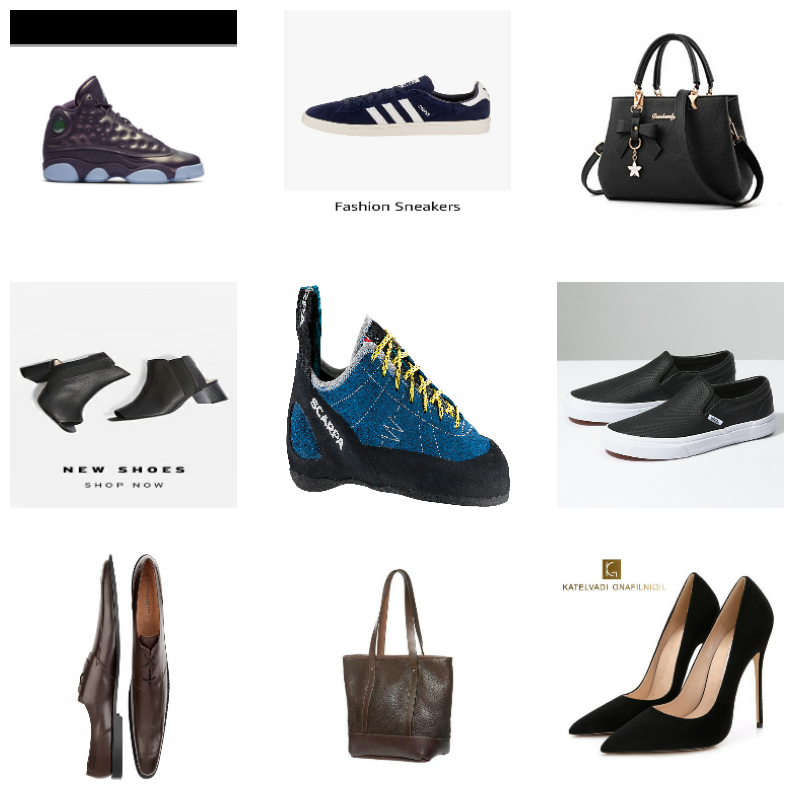

In [10]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
    for i in range(9):
        ax = plt.subplot(3, 3, i + 1)
        plt.imshow(images[i].numpy().astype("uint8"))
        plt.axis("off")

### Basic Attempt

In [11]:
patch_size = 16
image_size = 224

In [12]:
def get_patches(images, patch_size=16):
    input_shape = tf.shape(images) # Changed keras.ops.shape to tf.shape
    batch_size = input_shape[0]
    height = input_shape[1]
    width = input_shape[2]
    channels = input_shape[3]
    num_patches_h = height // patch_size
    num_patches_w = width // patch_size
    # key utility that breaks up an image into patches.
    # Returns batch_size x patch_index_i x patch_index_j x vectorized_patch_dimension
    patches = tf.image.extract_patches(images=images, # Added images= for clarity
                                      sizes=[1, patch_size, patch_size, 1],
                                      strides=[1, patch_size, patch_size, 1],
                                      rates=[1, 1, 1, 1],
                                      padding='VALID')
    # Using tf.reshape for consistency with other TensorFlow operations
    # Cast patches to float32 to ensure compatibility
    patches = tf.reshape(tf.cast(patches, dtype=tf.float32), # Cast patches to float32
        (
            batch_size,
            num_patches_h * num_patches_w,
            patch_size * patch_size * channels,
        ),
    )
    return patches


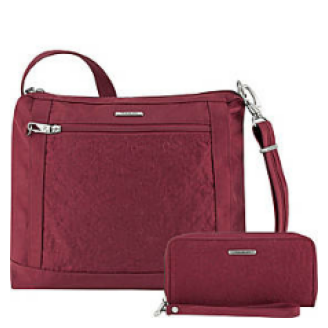

In [13]:
for images, _ in train_dataset.take(1):
    plt.figure(figsize=(4, 4))
    resized_image = keras.ops.image.resize(
        keras.ops.convert_to_tensor([images[0]]), size=(image_size, image_size)
    )
    no_channels = keras.ops.shape(resized_image)[-1]

    plt.imshow(images[0].numpy().astype("uint8"))
    plt.axis("off")

Image size: 224 X 224
Patch size: 16 X 16
Patches per image: 196
Elements per patch: 768


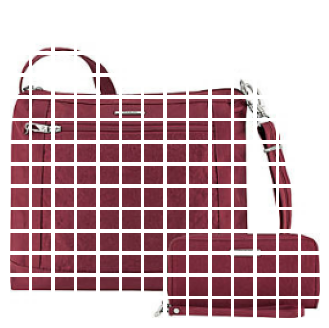

In [14]:
patches = get_patches(resized_image)
print(f"Image size: {image_size} X {image_size}")
print(f"Patch size: {patch_size} X {patch_size}")
print(f"Patches per image: {patches.shape[1]}")
print(f"Elements per patch: {patches.shape[-1]}")

n = int(np.sqrt(patches.shape[1]))
plt.figure(figsize=(4, 4))
for i, patch in enumerate(patches[0]):
    ax = plt.subplot(n, n, i + 1)
    patch_img = keras.ops.reshape(patch.numpy(), (16, 16, no_channels))
    plt.imshow(keras.ops.convert_to_numpy(patch_img).astype("uint8"))
    plt.axis("off")

In [15]:
#Recall num_patches is akin to the length of our context window
num_patches = (image_size // patch_size) ** 2

#Transformer dimensions
projection_dim = 64
num_heads = 8
transformer_units = [
    projection_dim * 2,
    projection_dim,
]  #no. units in the feedforward portion of the tranfomers
num_transformer_layers = 2

#Classification head dimensions
mlp_head_units = [
    512,
    256,
]

num_classes = 2
input_shape = (image_size, image_size, 3)

In [16]:
inputs = keras.Input(shape=input_shape)

# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])
x = data_augmentation(inputs)

# Create patches.
patches = Lambda(get_patches, output_shape=(num_patches, patch_size * patch_size * 3))(x)

# Encode patches by projecting and then adding a position embedding
projection = layers.Dense(units=projection_dim)
position_embedding = layers.Embedding(
            input_dim=num_patches, output_dim=projection_dim
        )
encoded_patches = projection(patches) + position_embedding(keras.ops.expand_dims(keras.ops.arange(start=0, stop=num_patches, step=1), axis=0))

# Create multiple layers of the Transformer block.
for _ in range(num_transformer_layers):
    # Layer normalization 1.
    x1 = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
    # Create a multi-head attention layer.
    attention_output = layers.MultiHeadAttention(
        num_heads=num_heads, key_dim=projection_dim, dropout=0.1
    )(x1, x1)
    # Skip connection 1.
    x2 = layers.Add()([attention_output, encoded_patches])
    # Layer normalization 2.
    x3 = layers.LayerNormalization(epsilon=1e-6)(x2)
    # MLP.
    for units in transformer_units:
        x3 = layers.Dense(units, activation=keras.activations.gelu)(x3)
        x3 = layers.Dropout(0.5)(x3)
    # Skip connection 2.
    encoded_patches = layers.Add()([x3, x2])


# Create a [batch_size, projection_dim] tensor.
representation = layers.LayerNormalization(epsilon=1e-6)(encoded_patches)
representation = layers.Flatten()(representation)
representation = layers.Dropout(0.5)(representation)

# Add MLP.
for units in mlp_head_units:
    representation = layers.Dense(units, activation=keras.activations.gelu)(representation)
    representation = layers.Dropout(0.5)(representation)

# Classify outputs.
logits = layers.Dense(num_classes)(representation)

# Create the Keras model.
model = keras.Model(inputs=inputs, outputs=logits)

In [17]:
optimizer = keras.optimizers.AdamW(
    learning_rate=0.001
)

model.compile(
    optimizer=optimizer,
    loss=keras.losses.CategoricalCrossentropy(from_logits=True),
    metrics=[
        keras.metrics.CategoricalAccuracy(name="accuracy"),
    ],
)

model.summary()

Model: "functional_1"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer         │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ sequential          │ (None, 224, 224,  │          0 │ input_layer[0][0] │
│ (Sequential)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ lambda (Lambda)     │ (None, 196, 768)  │          0 │ sequential[0][0]  │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense (Dense)       │ (None, 196, 64)   │     49,216 │ lambda[0][0]      │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add (Add)           │ (None, 196, 64)   │          0 │ dense[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalization │ (None, 196, 64)   │        128 │ add[0][0]         │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_1 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add[0][0]         │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_1[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_1 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_1 (Dropout) │ (None, 196, 128)  │          0 │ dense_1[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_2 (Dense)     │ (None, 196, 64)   │      8,256 │ dropout_1[0][0]   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dropout_2 (Dropout) │ (None, 196, 64)   │          0 │ dense_2[0][0]     │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_2 (Add)         │ (None, 196, 64)   │          0 │ dropout_2[0][0],  │
│                     │                   │            │ add_1[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_2[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ multi_head_attenti… │ (None, 196, 64)   │    132,672 │ layer_normalizat… │
│ (MultiHeadAttentio… │                   │            │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ add_3 (Add)         │ (None, 196, 64)   │          0 │ multi_head_atten… │
│                     │                   │            │ add_2[0][0]       │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ layer_normalizatio… │ (None, 196, 64)   │        128 │ add_3[0][0]       │
│ (LayerNormalizatio… │                   │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ dense_3 (Dense)     │ (None, 196, 128)  │      8,320 │ layer_normalizat… │
├─────────────────────┼───────────────────┼────────────┼─────────────────

 Total params: 6,903,234 (26.33 MB)

 Trainable params: 6,903,234 (26.33 MB)

 Non-trainable params: 0 (0.00 B)

In [18]:
# Before calling fit, build the model with a sample input:
sample_input = tf.zeros((32, image_size, image_size, 3))
model(sample_input)  # Build the model


history = model.fit(
    train_dataset,  # Replace with your dataset
    validation_data=validation_dataset,
    epochs=40,  # Train for a few epochs initially
    batch_size=32
)

Epoch 1/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 20s 906ms/step - accuracy: 0.5000 - loss: 7.1297 - val_accuracy: 0.4898 - val_loss: 2.8120
Epoch 2/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 399ms/step - accuracy: 0.5104 - loss: 3.9656 - val_accuracy: 0.4898 - val_loss: 5.3070
Epoch 3/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 279ms/step - accuracy: 0.5000 - loss: 4.4513 - val_accuracy: 0.5102 - val_loss: 3.2304
Epoch 4/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 297ms/step - accuracy: 0.5938 - loss: 3.7481 - val_accuracy: 0.4898 - val_loss: 2.4053
Epoch 5/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 299ms/step - accuracy: 0.5521 - loss: 4.0012 - val_accuracy: 0.5102 - val_loss: 2.9103
Epoch 6/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 2s 511ms/step - accuracy: 0.3854 - loss: 5.2438 - val_accuracy: 0.5102 - val_loss: 1.0625
Epoch 7/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 558ms/step - accuracy: 0.5000 - loss: 3.5612 - val_accuracy: 0.5102 - val_loss: 0.7364
Epoch 8/40
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 339ms/step - accuracy: 0.5312 - loss: 2.8056 - val_accuracy: 0.5102 - val_loss

### Finetuning

In [19]:
# Load the ViT backbone and preprocessor
backbone = keras_hub.models.Backbone.from_preset("vit_base_patch16_224_imagenet")
preprocessor = keras_hub.models.ViTImageClassifierPreprocessor.from_preset(
    "vit_base_patch16_224_imagenet"
)

# Define data augmentation pipeline
data_augmentation = keras.Sequential([
    keras.layers.RandomFlip("horizontal"),
    keras.layers.RandomRotation(0.1),
    keras.layers.RandomZoom(0.1),
    keras.layers.RandomTranslation(0.1, 0.1),
])

# Create the custom model
inputs = keras.Input(shape=(224, 224, 3))  # Input shape for the images
x = data_augmentation(inputs)              # Apply data augmentation
x = preprocessor(x)                   # Preprocess inputs for ViT
x = backbone(x, training=True)             # Pass through the ViT backbone
x = Flatten()(x)                           # Flatten the ViT outputs
x = Dense(backbone.hidden_dim, activation="linear")(x)  # Project down to the hidden dimension
x = Dropout(0.5)(x)                        # Add dropout for regularization
x = Dense(256, activation="relu")(x)       # Add a dense layer for feature learning
x = Dropout(0.5)(x)                        # Another dropout layer
outputs = Dense(2, activation="softmax")(x)  # Final classification layer

# Create the model
model = keras.Model(inputs, outputs)

# Summary of the model
model.summary()

100%|██████████| 698/698 [00:00<00:00, 1.74MB/s]


100%|██████████| 328M/328M [00:08<00:00, 41.1MB/s]


100%|██████████| 1.74k/1.74k [00:00<00:00, 3.19MB/s]


Model: "functional_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_2 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ sequential_1 (Sequential)       │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_image_classifier_preproce… │ (None, 224, 224, 3)    │             0 │
│ (ViTImageClassifierPreprocesso… │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ vi_t_backbone (ViTBackbone)     │ (None, 197, 768)       │    85,798,656 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_1 (Flatten)             │ (None, 151296)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_8 (Dense)                 │ (None, 768)            │   116,196,096 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_21 (Dropout)            │ (None, 768)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_9 (Dense)                 │ (None, 256)            │       196,864 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_22 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_10 (Dense)                │ (None, 2)              │           514 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 202,192,130 (771.30 MB)

 Trainable params: 202,192,130 (771.30 MB)

 Non-trainable params: 0 (0.00 B)

In [20]:
# Freeze the backbone initially
backbone.trainable = False

# Compile the model for initial training
model.compile(
    optimizer=keras.optimizers.Adam(learning_rate=1e-4),
    loss="categorical_crossentropy",
    metrics=["accuracy"],
)

# Train only the classification head
history = model.fit(
    train_dataset,  # Replace with your dataset
    validation_data=validation_dataset,
    epochs=2,  # Train for a few epochs initially
    batch_size=32
)

Epoch 1/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 17s 2s/step - accuracy: 0.8542 - loss: 0.8798 - val_accuracy: 1.0000 - val_loss: 9.6780e-06
Epoch 2/2
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 1s/step - accuracy: 0.9896 - loss: 0.0911 - val_accuracy: 0.9796 - val_loss: 0.2358


In [21]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 202ms/step - accuracy: 1.0000 - loss: 0.0000e+00


[0.0, 1.0]

## A Basic Convolutional Neural Network



---



---



We will try a simple CNN on this dataset with two convolutional blocks.

In [27]:
input = keras.Input(shape=(224,224,3))

# we normalize "inside" the model with a Rescaling layer
# so that we don't have to remember to do it every time
# we need to use the model to make a prediction
h = keras.layers.Rescaling(1./255)(input)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_1")(h)
h = keras.layers.MaxPool2D()(h)


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_2")(h)
h = keras.layers.MaxPool2D()(h)

# flatten layer
h = keras.layers.Flatten()(h)

# output layer
output = keras.layers.Dense(num_classes, activation="softmax")(h)

model = keras.Model(input, output)

In [23]:
model.summary()

Model: "functional_4"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_4 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling (Rescaling)           │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_2 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_11 (Dense)                │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

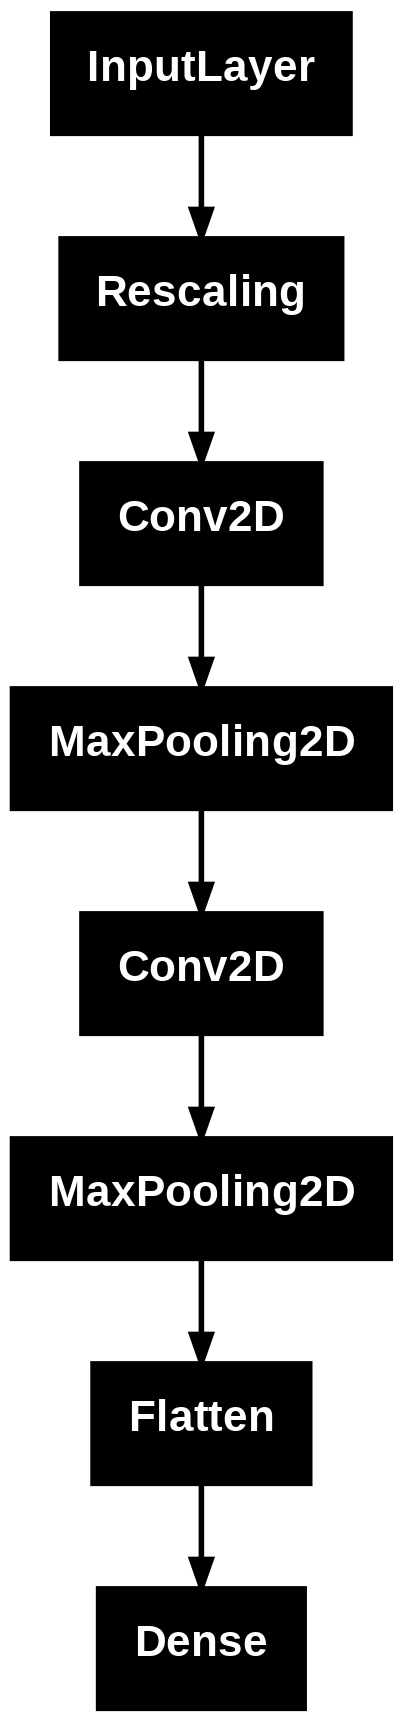

In [24]:
keras.utils.plot_model(model)

In [28]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

Note that we chose the `binary_cross_entropy` loss function above since this is just a **binary** classification problem (e.g., handbags or shoes).

As usual, we will tell Keras to track loss and accuracy on the **validation** set so we can keep an eye on any overfitting.

We will also store the results of running `model.fit` in the variable `history`. This will allow us to plot how the loss and accuracy changed from epoch to epoch etc. and thereby get a sense for any overfitting.

In [30]:
history = model.fit(train_dataset,
                    epochs=20,
                    validation_data=validation_dataset)

Epoch 1/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 294ms/step - accuracy: 1.0000 - loss: 0.0019 - val_accuracy: 0.7959 - val_loss: 0.6092
Epoch 2/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 248ms/step - accuracy: 1.0000 - loss: 0.0020 - val_accuracy: 0.7959 - val_loss: 0.6061
Epoch 3/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 480ms/step - accuracy: 1.0000 - loss: 0.0015 - val_accuracy: 0.8163 - val_loss: 0.6100
Epoch 4/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 538ms/step - accuracy: 1.0000 - loss: 0.0013 - val_accuracy: 0.8163 - val_loss: 0.6223
Epoch 5/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 291ms/step - accuracy: 1.0000 - loss: 0.0010 - val_accuracy: 0.8163 - val_loss: 0.6259
Epoch 6/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 268ms/step - accuracy: 1.0000 - loss: 8.9404e-04 - val_accuracy: 0.7959 - val_loss: 0.6450
Epoch 7/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 269ms/step - accuracy: 1.0000 - loss: 8.3712e-04 - val_accuracy: 0.7959 - val_loss: 0.6587
Epoch 8/20
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 293ms/step - accuracy: 1.0000 - loss: 7.5513e-04 - val_accuracy: 0.8163

In [31]:
def plot_loss_curves(history):
  plt.clf()
  history_dict = history.history
  loss_values = history_dict["loss"]
  val_loss_values = history_dict["val_loss"]
  epochs = range(1, len(loss_values) + 1)
  plt.plot(epochs, loss_values, "bo", label="Training loss")
  plt.plot(epochs, val_loss_values, "b", label="Validation loss")
  plt.title("Training and validation loss")
  plt.xlabel("Epochs")
  plt.ylabel("Loss")
  plt.legend()
  plt.show()

def plot_acc_curves(history):
  plt.clf()
  history_dict = history.history
  acc = history_dict["accuracy"]
  val_acc = history_dict["val_accuracy"]
  epochs = range(1, len(acc) + 1)
  plt.plot(epochs, acc, "bo", label="Training acc")
  plt.plot(epochs, val_acc, "b", label="Validation acc")
  plt.title("Training and validation accuracy")
  plt.xlabel("Epochs")
  plt.ylabel("Accuracy")
  plt.legend()
  plt.show()

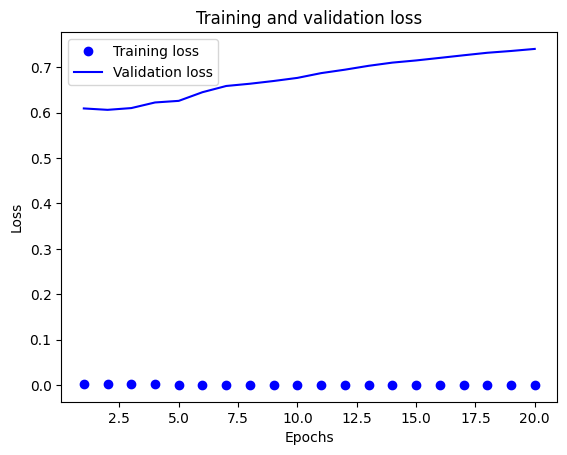

In [41]:
plot_loss_curves(history)

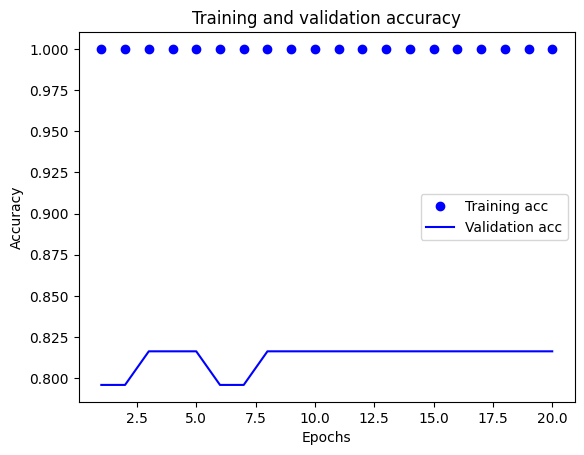

In [42]:
plot_acc_curves(history)

The model achieves a high training accuracy. This is not surprising, since our training dataset has only ~90 examples while our model has 101,345 parameters!

The validation accuracy curve is very noisy because the validation dataset is only 49 examples but it is clear there's a gap between training and validation accuracy curves, suggesting **overfitting**.




Let's check the accuracy on the test set.

In [34]:
model.evaluate(test_dataset)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 661ms/step - accuracy: 0.8000 - loss: 0.8127


[0.8127086758613586, 0.800000011920929]

OK, what can we do to improve accuracy?

We can go back and scrape more data, of course, but that is a lot of work.

What else?

## Data Augmentation for Images

The basic idea of augmentation is to slightly alter the image so that the value of the dependent variable (i.e. the category that it belongs to) doesn't change. For instance, if you rotate the image of a handbag by 10 degrees or zoom in on it slightly, the content of the image doesn't change; it is *still* a handbag.

By applying these transformations repeatedly to an image, you can create new images and thereby increase the size of the dataset almost effortlessly.

Researchers have developed a list of these transformations that you can apply to images and Keras provides them out of the box as different kinds of *layers*.



---



---



To demonstrate, here's a little function that applies three transformations to an incoming image.


In [35]:
def augment_data(image):
  x = keras.layers.RandomFlip("horizontal")(image)
  x = keras.layers.RandomRotation(0.1)(x)
  x = keras.layers.RandomZoom(0.2)(x)
  return x

Let's apply it to an image from our training set to see what it produces.

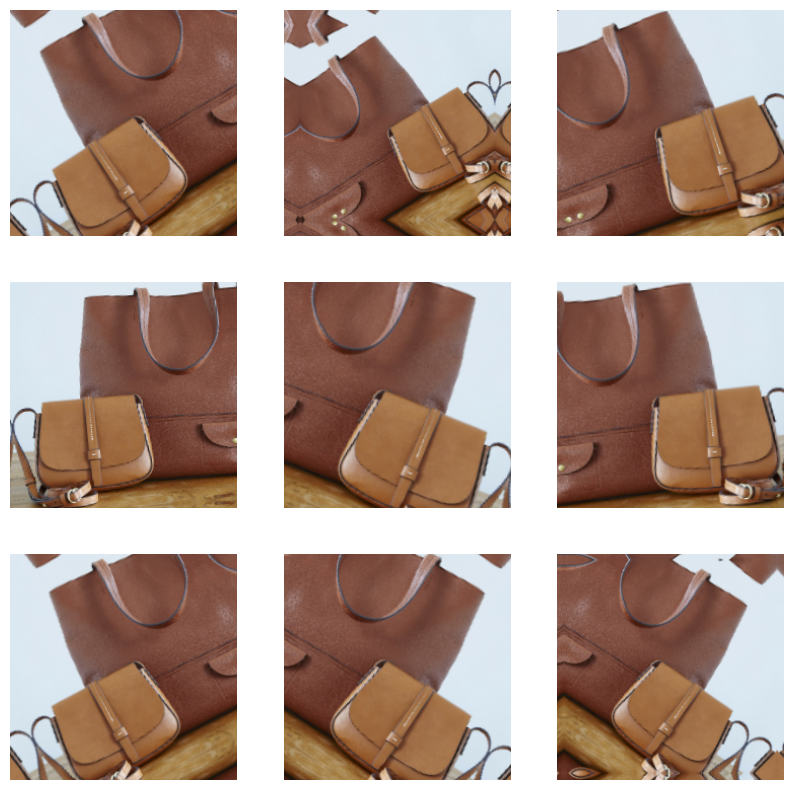

In [36]:
plt.figure(figsize=(10, 10))
for images, _ in train_dataset.take(1):
  for i in range(9):
    ax = plt.subplot(3, 3, i + 1)
    augmented_image = augment_data(images[0])
    plt.imshow(augmented_image.numpy().astype("uint8"))
    plt.axis("off")

We can insert these  data augmentation layers right after the input layer in the convolutional NN model we built earlier, and train the model as before. Also, because we have effectively more data now, we can train this data-augmented model for more epochs at a lower risk of overfitting.

In [44]:
input = keras.Input(shape=(224,224,3))

# we insert the data augmentation layers here
h = keras.layers.RandomFlip("horizontal")(input)
h = keras.layers.RandomRotation(0.1)(h)
h = keras.layers.RandomZoom(0.2)(h)

# rest of the model is the same as before

h = keras.layers.Rescaling(1./255)(h)


# first convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_1")(h)
h = keras.layers.MaxPool2D()(h)


# second convolutional block
h = keras.layers.Conv2D(32,                    # the number of filters
                        kernel_size=(2, 2),    # the shape of each filter
                        activation="relu",
                        name="Conv_2")(h)
h = keras.layers.MaxPool2D()(h)

# flatten layer
h = keras.layers.Flatten()(h)

# output layer
output = keras.layers.Dense(num_classes, activation="softmax")(h)

model = keras.Model(input, output)

In [38]:
model.summary()

Model: "functional_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_6 (InputLayer)      │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_flip_11 (RandomFlip)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_rotation_11              │ (None, 224, 224, 3)    │             0 │
│ (RandomRotation)                │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ random_zoom_11 (RandomZoom)     │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ rescaling_2 (Rescaling)         │ (None, 224, 224, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_1 (Conv2D)                 │ (None, 223, 223, 32)   │           416 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_4 (MaxPooling2D)  │ (None, 111, 111, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ Conv_2 (Conv2D)                 │ (None, 110, 110, 32)   │         4,128 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_5 (MaxPooling2D)  │ (None, 55, 55, 32)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_4 (Flatten)             │ (None, 96800)          │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_13 (Dense)                │ (None, 1)              │        96,801 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 101,345 (395.88 KB)

 Trainable params: 101,345 (395.88 KB)

 Non-trainable params: 0 (0.00 B)

In [60]:
model.compile(loss='categorical_crossentropy',
             optimizer='adam',
             metrics=['accuracy'])

In [61]:
history = model.fit(train_dataset,
                    epochs=10,
                    validation_data=validation_dataset)

Epoch 1/10


ValueError: Input 0 with name 'input_layer_9' of layer 'functional_8' is incompatible with the layer: expected shape=(None, 7, 7, 2048), found shape=(None, 224, 224, 3)

In the interest of time, we won't train this model. We encourage you to do so and evaluate if the data augmentation improves the accuracy on the test set.

## Model built with Transfer Learning


**SWITCH TO PPT FOR TRANSFER LEARNING**




---

We will work with ResNet-50 (rather than ResNet-34 as shown in the picture below) since it comes pre-packaged with Keras.

Check out all the pre-trained models available in [Keras](https://keras.io/api/applications/) and in [Tensorflow](https://www.tensorflow.org/hub).



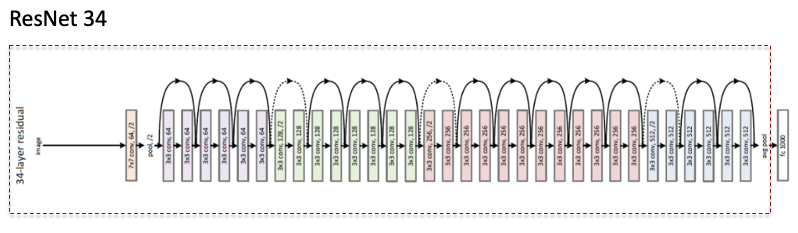

In [48]:
resnet50_base = keras.applications.ResNet50(
  weights='imagenet',
  include_top=False,
  input_shape=(224, 224, 3))

94765736/94765736 ━━━━━━━━━━━━━━━━━━━━ 0s 0us/step


In [49]:
resnet50_base.summary()

Model: "resnet50"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_8       │ (None, 224, 224,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_pad           │ (None, 230, 230,  │          0 │ input_layer_8[0]… │
│ (ZeroPadding2D)     │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_conv (Conv2D) │ (None, 112, 112,  │      9,472 │ conv1_pad[0][0]   │
│                     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_bn            │ (None, 112, 112,  │        256 │ conv1_conv[0][0]  │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv1_relu          │ (None, 112, 112,  │          0 │ conv1_bn[0][0]    │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pad           │ (None, 114, 114,  │          0 │ conv1_relu[0][0]  │
│ (ZeroPadding2D)     │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ pool1_pool          │ (None, 56, 56,    │          0 │ pool1_pad[0][0]   │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_conv │ (None, 56, 56,    │      4,160 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_bn   │ (None, 56, 56,    │        256 │ conv2_block1_1_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_1_relu │ (None, 56, 56,    │          0 │ conv2_block1_1_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_conv │ (None, 56, 56,    │     36,928 │ conv2_block1_1_r… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_bn   │ (None, 56, 56,    │        256 │ conv2_block1_2_c… │
│ (BatchNormalizatio… │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_2_relu │ (None, 56, 56,    │          0 │ conv2_block1_2_b… │
│ (Activation)        │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_conv │ (None, 56, 56,    │     16,640 │ pool1_pool[0][0]  │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_conv │ (None, 56, 56,    │     16,640 │ conv2_block1_2_r… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_0_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_0_c… │
│ (BatchNormalizatio… │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ conv2_block1_3_bn   │ (None, 56, 56,    │      1,024 │ conv2_block1_3_c

 Total params: 23,587,712 (89.98 MB)

 Trainable params: 23,534,592 (89.78 MB)

 Non-trainable params: 53,120 (207.50 KB)

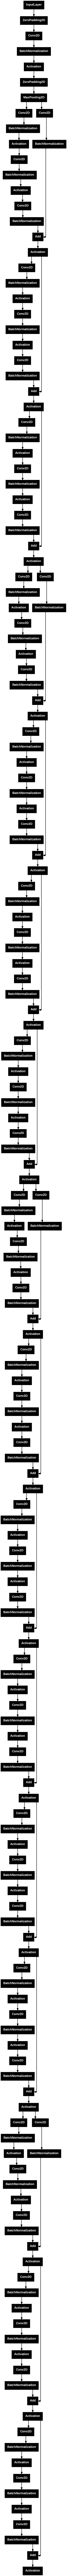

In [50]:
keras.utils.plot_model(resnet50_base)

It is a **DEEP** network, all right!!

Next, we run our dataset through "headless ResNet" to get the transformed, "smart" inputs.


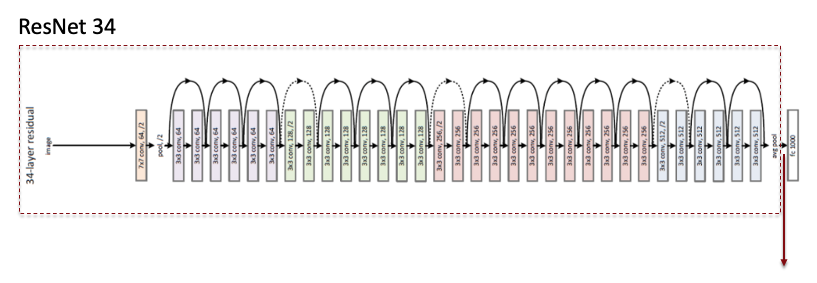

In [51]:
def get_features_and_labels(dataset):
  all_features = []
  all_labels = []
  for images, labels in dataset:
    preprocessed_images = keras.applications.resnet50.preprocess_input(images)
    features = resnet50_base.predict(preprocessed_images)
    all_features.append(features)
    all_labels.append(labels)
  return np.concatenate(all_features), np.concatenate(all_labels)

In [52]:
train_features, train_labels =  get_features_and_labels(train_dataset)
val_features, val_labels =  get_features_and_labels(validation_dataset)
test_features, test_labels =  get_features_and_labels(test_dataset)

1/1 ━━━━━━━━━━━━━━━━━━━━ 9s 9s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 116ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 112ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 5s 5s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 125ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step


What's the shape of the tensor that comes out of 'headless' ResNet?

In [53]:
train_features.shape

(96, 7, 7, 2048)

These tensors coming out of "headless" ResNet are smart representations and we can simply attach them to a small NN.  

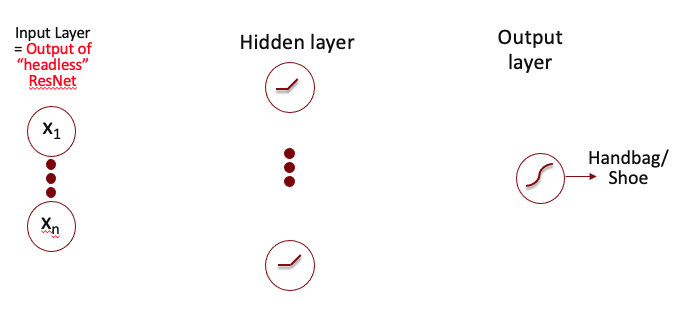


We will use a regularization layer that we haven't yet used: `Dropout`.

In [62]:
input = keras.Input(shape=(7, 7, 2048))

h = keras.layers.Flatten()(input)

h = keras.layers.Dense(256, activation="relu")(h)

h = keras.layers.Dropout(0.5)(h) # first time we are using this!

output = keras.layers.Dense(num_classes, activation="softmax")(h)

model = keras.Model(input, output)

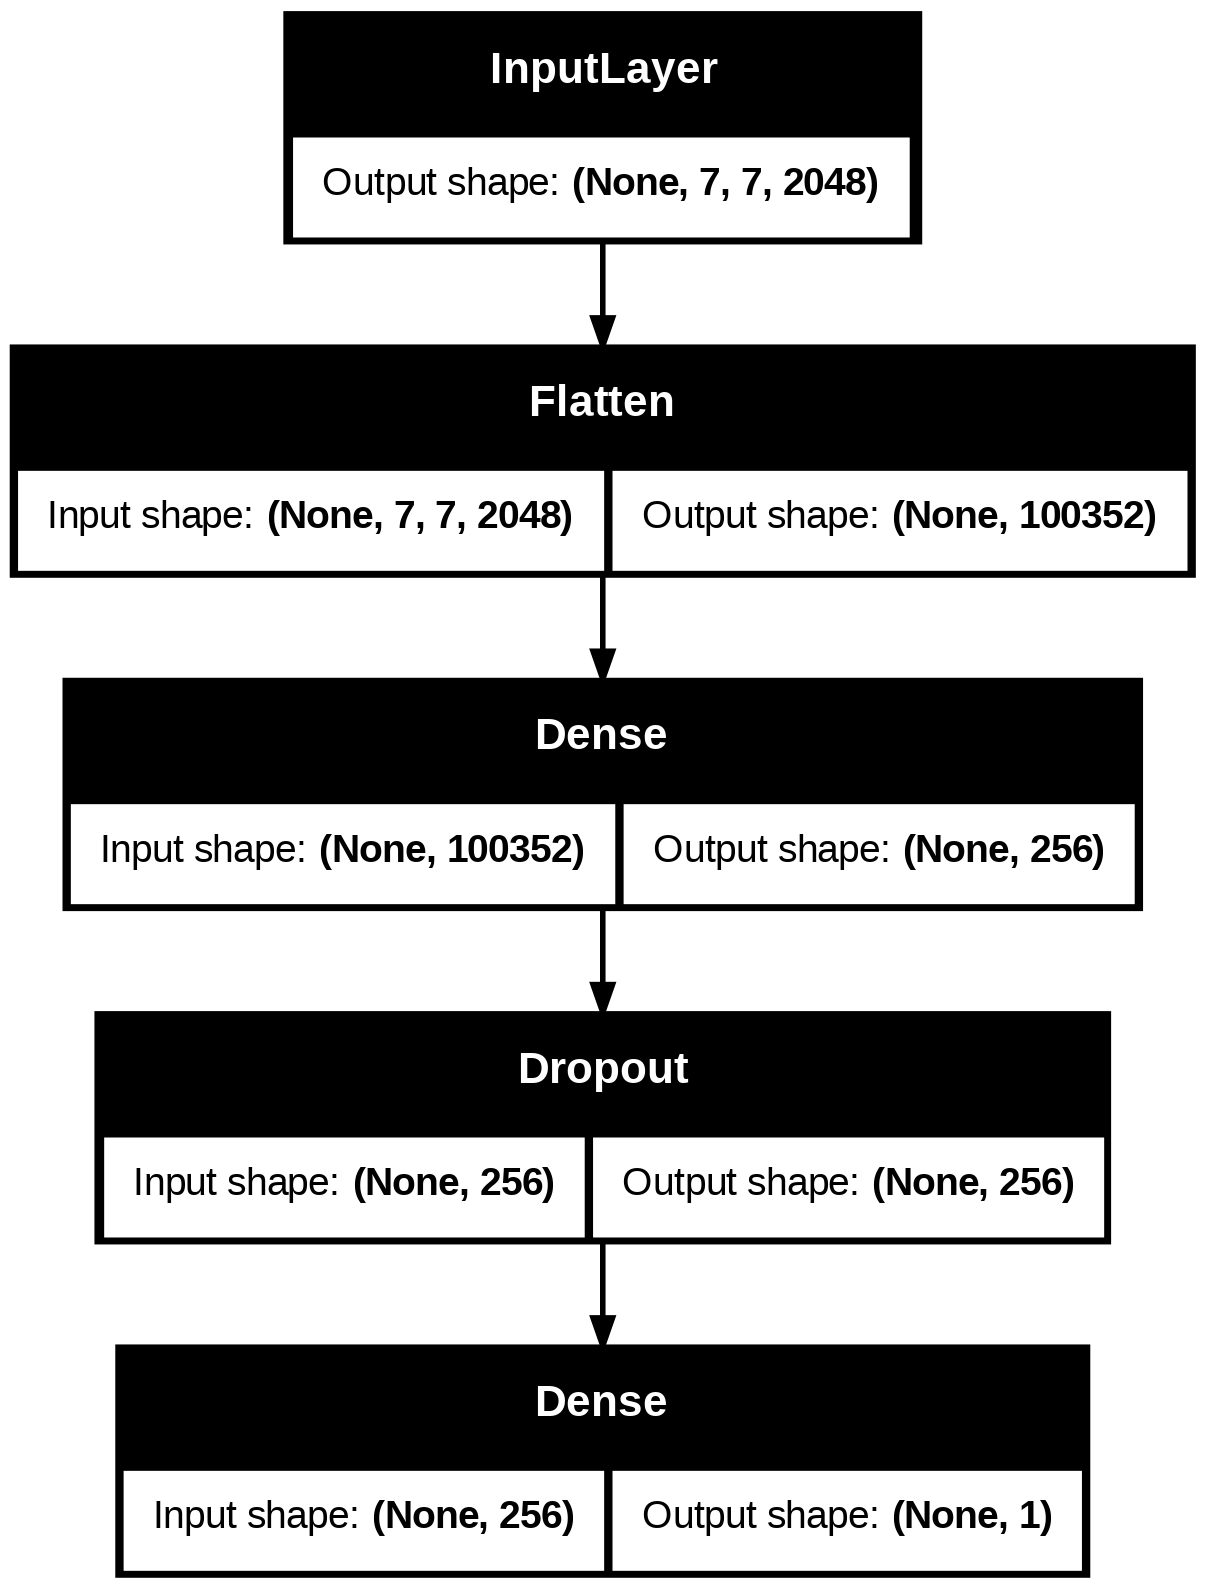

In [55]:
keras.utils.plot_model(model, show_shapes=True)

In [56]:
model.summary()

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer_9 (InputLayer)      │ (None, 7, 7, 2048)     │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ flatten_6 (Flatten)             │ (None, 100352)         │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_15 (Dense)                │ (None, 256)            │    25,690,368 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dropout_23 (Dropout)            │ (None, 256)            │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_16 (Dense)                │ (None, 1)              │           257 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 25,690,625 (98.00 MB)

 Trainable params: 25,690,625 (98.00 MB)

 Non-trainable params: 0 (0.00 B)

In [63]:
model.compile(loss='categorical_crossentropy',
              optimizer='adam',
              metrics=['accuracy'])

history = model.fit(train_features,
                    train_labels,
                    epochs=10,
                    validation_data=(val_features, val_labels))

Epoch 1/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 3s 452ms/step - accuracy: 0.7917 - loss: 1.6702 - val_accuracy: 0.9796 - val_loss: 1.3946
Epoch 2/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 42ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9592 - val_loss: 3.5866
Epoch 3/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9792 - loss: 0.3810 - val_accuracy: 0.9796 - val_loss: 1.0797
Epoch 4/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 0.9896 - loss: 0.2746 - val_accuracy: 1.0000 - val_loss: 0.0000e+00
Epoch 5/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 0.9896 - loss: 0.3481 - val_accuracy: 0.9796 - val_loss: 0.0587
Epoch 6/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 38ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9796 - val_loss: 1.1768
Epoch 7/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.9796 - val_loss: 1.9692
Epoch 8/10
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 39ms/step - accuracy: 1.0000 - loss: 0.0000e+00 - val_accuracy: 0.979

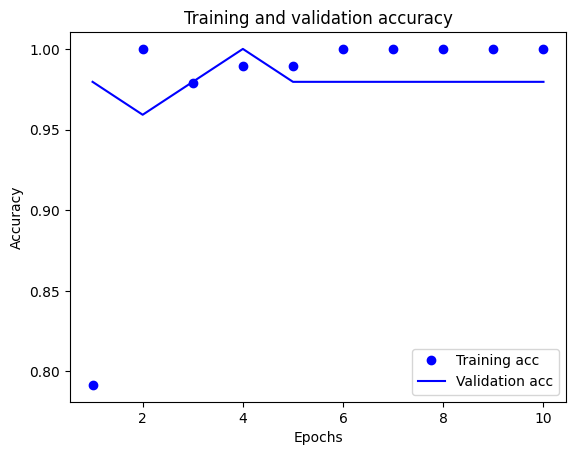

In [64]:
plot_acc_curves(history)

The training and validation accuracies are both very high! This looks promising!

In [65]:
model.evaluate(test_features, test_labels)

2/2 ━━━━━━━━━━━━━━━━━━━━ 1s 574ms/step - accuracy: 1.0000 - loss: 0.0000e+00


[0.0, 1.0]

**IMPRESSIVE ACCURACY ON THE TEST SET!!**


Let's pause for a moment to reflect on what we have done.

We have built an amazingly accurate handbags or shoes classifier with *just* 100 training images!

That's the power of transfer learning!!

OK, let's test it **LIVE** with my laptop's webcam.

In [66]:
# Camera Capture code snippet courtesy Google Colab


from IPython.display import display, Javascript
from google.colab.output import eval_js
from base64 import b64decode

def take_photo(filename='photo.jpg', quality=0.8):
  js = Javascript('''
    async function takePhoto(quality) {
      const div = document.createElement('div');
      const capture = document.createElement('button');
      capture.textContent = 'Capture';
      div.appendChild(capture);

      const video = document.createElement('video');
      video.style.display = 'block';
      const stream = await navigator.mediaDevices.getUserMedia({video: true});

      document.body.appendChild(div);
      div.appendChild(video);
      video.srcObject = stream;
      await video.play();

      // Resize the output to fit the video element.
      google.colab.output.setIframeHeight(document.documentElement.scrollHeight, true);

      // Wait for Capture to be clicked.
      await new Promise((resolve) => capture.onclick = resolve);

      const canvas = document.createElement('canvas');
      canvas.width = video.videoWidth;
      canvas.height = video.videoHeight;
      canvas.getContext('2d').drawImage(video, 0, 0);
      stream.getVideoTracks()[0].stop();
      div.remove();
      return canvas.toDataURL('image/jpeg', quality);
    }
    ''')
  display(js)
  data = eval_js('takePhoto({})'.format(quality))
  binary = b64decode(data.split(',')[1])
  with open(filename, 'wb') as f:
    f.write(binary)
  return filename



In [67]:
def predict_image(im):
  img = keras.preprocessing.image.load_img(im, target_size=(224,224))
  arr = keras.preprocessing.image.img_to_array(img)
  arr = keras.applications.resnet50.preprocess_input(arr)
  arr = np.expand_dims(arr, axis=0)
  arr = resnet50_base(arr)
  pred = model.predict(arr)
  pred = "SHOE" if pred > 0.5 else "HANDBAG"
  print("************************************\n\n")
  print(f"...........it is a {pred}!")
  print("\n\n************************************\n\n")

<IPython.core.display.Javascript object>

Saved to photo.jpg


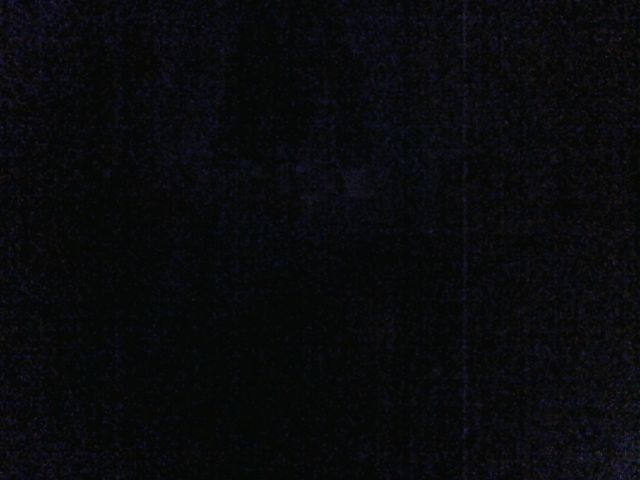

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 488ms/step
The truth value of an array with more than one element is ambiguous. Use a.any() or a.all()


In [69]:
# Camera Capture code snippet courtesy Google Colab

from IPython.display import Image
try:
  filename = take_photo()
  print('Saved to {}'.format(filename))

  # Show the image which was just taken.
  display(Image(filename))
  predict_image(filename)
except Exception as err:
  # Errors will be thrown if the user does not have a webcam or if they do not
  # grant the page permission to access it.
  print(str(err))

**THE END**